<a href="https://colab.research.google.com/github/lilfetz22/Health_Scores_CAP2/blob/master/scripts/ML_no_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Scores Machine Learning

How healthy is your city? This notebook goes through the process of determining how your city ranks among the top 500 cities in the United States. The data that is brought in this notebook were manipulated in Health_scores_EDA jupyter notebook. The data did not come with any labels for classification; thus, this notebook uses several classification methods to then complete the classification models. This notebook begins by using the following clusterization techniques: 


1.   KMeans
2.   Decision Tree
3.   Optics
4.   Hierarchical Clustering
5.   HBDSCAN
6.   Affinity Propagation

Next the data was classified using classification models predicting the clusters. The following models were used during classification:



1.   Logistic Regression
2.   Decision Tree
3.   Random Forest
4.   LightGBM
5.   XGBoost


The models were then compared with each classification method and clusterization labels. The best combination appeared to be using ________ classification and __________ clustering. 

Finally, each location was given a rank for each feature. The feature importances found from the classification model were used to weight the features producing a score for each feature in each location. The location was scored based upon all features and given an **Overall Health Score** 







In [1]:
!pip install -q hdbscan

     |████████████████████████████████| 4.9MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import seaborn as sns
import warnings
import io
import lightgbm as lgb
import xgboost as xgb
import re
import hdbscan
from random import seed, randint,sample
from sklearn.cluster import OPTICS,KMeans,AgglomerativeClustering,AffinityPropagation
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, silhouette_samples, silhouette_score, 
calinski_harabasz_score, davies_bouldin_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from google.colab import drive
from numba import jit

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
city_data_scaled = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/city_data_scaled.csv",
                               index_col='stpl_fips')
tract_data_scaled = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/tract_data_scaled.csv",
                               index_col='stcotr_fips')
city_data_manip = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/city_data_manip.csv",
                               index_col='stpl_fips')
tract_data_manip = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/tract_data_manip.csv",
                               index_col='stcotr_fips')
leri_city = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/leri_city.csv",
                               index_col='stpl_fips')
leri_tract = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/leri_tract.csv",
                               index_col='stcotr_fips')
kmeans_city_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/kmeans_city_df.csv',
                             index_col='stpl_fips')
kmeans_tract_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/kmeans_tract_df.csv',
                              index_col='stcotr_fips')
optic_city_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/optic_city_df.csv',
                              index_col='stpl_fips')
optic_tract_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/optic_tract_df.csv',
                              index_col='stcotr_fips')
hdbs_city_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/hdbs_city_df.csv',
                              index_col='stpl_fips')
hdbs_tract_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/hdbs_tract_df.csv',
                              index_col='stcotr_fips')
agg_city_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/agg_city_df.csv',
                              index_col='stpl_fips')
agg_tract_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/agg_tract_df.csv',
                              index_col='stcotr_fips')
aff_city_df = pd.read_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/aff_city_df.csv',
                              index_col='stpl_fips')

In [0]:
city_data_scaled.name = 'city'
tract_data_scaled.name = 'tract'

## Clustering

clusterings have been saved in csv files that are all imported above

In [8]:

silhouette_score(city_data_scaled, optic_city_df['optic_cluster'])

0.029302681242652603

# Classification

#### Logistic Regression

In [0]:
# scoring classification models
@jit
def cv_score(clf, x, y, score_func=accuracy_score):
  '''This is a custom metric for scoring models. 

  args: 
      clf - classification model
      x - independent variables
      y - response variable
      score_func - type of scoring metric to use on data
  returns: the average score for the model

  '''
  result=0
  nfold=5
  for train, test in KFold(nfold).split(x):
      clf.fit(x[train],y[train])
      result += score_func(clf.predict(x[test]), y[test])
  return result/nfold #average

In [0]:
# using kmeans clustering
warnings.filterwarnings('ignore')
@jit
def logreg_fx(data, data_cluster):
  ''' This function goes through the process of creating a DecisionTreeClassifier 
  model, going through a cross validation, parameter tuning, and a stratified 
  KFold cross validation for an average score using accuracy score metric

  args: 
  data - dataframe (city/tract)
  data_clusters - the copy of the dataframe with a column that has the 
  clusterization labels added on the last column the input into this argument 
  should be a pandas series of that column that contains the cluster labels

  returns: average accuracy score
  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  c_space = np.logspace(0.001, 0.1, 1, 10, 100)
  logreg = LogisticRegression()
  param_grid = {'C': c_space}
  logreg_cv = GridSearchCV(logreg, param_grid, cv=5) #parameter tuning
  logreg_cv.fit(X_tr, y_tr)

  print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
  print("Best score is {}".format(logreg_cv.best_score_))
  logreg_best = LogisticRegression(C=logreg_cv.best_params_['C'])
  score = cv_score(logreg_best, X_tr, y_tr)
  return score

#### Decision Tree

In [0]:
@jit
def dt_fx(data, data_cluster):
  ''' This function goes through the process of creating a DecisionTreeClassifier 
  model, going through a cross validation, parameter tuning, and a stratified 
  KFold cross validation for an average score using accuracy score metric

            args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: average accuracy score

  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                        random_state=5)
  dt = DecisionTreeClassifier()
  dt_base_fit = dt.fit(X_tr, y_tr)
  dt_base_pred = dt_base_fit.predict(X_test)
  dt_base_score = accuracy_score(y_test, dt_base_pred)
  print("Baseline Score: {}".format(dt_base_score))
  
  md = np.linspace(1,32,32,endpoint=True)
  min_samples = np.linspace(0.1,1,10,endpoint=True)
  mleaf = np.linspace(0.1,0.5,5,endpoint=True)
  maxfeat = list(range(1,X_tr.shape[1]))
  param_grid = {'max_depth': md, 'min_samples_split': min_samples, 'min_samples_leaf': mleaf, 
                'max_features': maxfeat}
  dt_cv = GridSearchCV(dt,param_grid, cv=5, scoring='accuracy')
  dt_cv.fit(X_tr,y_tr)
  print("Tuned Parameters: {}".format(dt_cv.best_params_)) 
  print("Best score is {}".format(dt_cv.best_score_))
  dt_best = DecisionTreeClassifier(max_depth = dt_cv.best_params_['max_depth'],
                                  min_samples_split = dt_cv.best_params_['min_samples_split'],
                                  min_samples_leaf = dt_cv.best_params_['min_samples_leaf'],
                                  max_features = dt_cv.best_params_['max_features'])
  dt_best_fit = dt_best.fit(X_tr, y_tr)
  dt_best_pred = dt_best_fit.predict(X_test)
  dt_score = accuracy_score(y_test, dt_best_pred)
  return dt_score

#### Random Forest

In [0]:
@jit
def rf_fx(data, data_cluster):
  ''' This function goes through the process of creating a RandomForestClassifier 
  model. Model is fit to the training data and an accuracy score is printed. 

            args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: dataframe of feature importances, average accuracy score

  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  mod = RandomForestClassifier()
  mod_base_fit = mod.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  mod_base_score = accuracy_score(y_test, mod_base_pred)
  # print("Baseline Score: {}".format(mod_base_score))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df, mod_base_score

#### Light GBM

In [0]:
@jit
def gbm_fx(data, data_cluster):
  ''' This function creates a LGBMRanker model, best attempts were made to have 
  an evaluation metric work with this function but to no avail. 

  args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: dataframe of feature importances
  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  evaluation_dict = {}
  gbm = lgb.LGBMRanker()
  q_train = [X_tr.shape[0]]
  mod_base_fit = gbm.fit(X_tr, y_tr, group=q_train, callbacks=[lgb.record_evaluation(evaluation_dict)])
  mod_base_pred = mod_base_fit.predict(X_test)
  

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df

In [0]:
@jit
def gbm_Class_fx(data, data_cluster):
  ''' This function goes through the process of creating a LGBMClassifier model, 
  going through a cross validation, plotting the importance of each feature, 
  and a stratified KFold cross validation for an average score using accuracy 
  score metric

  args: 
  data - dataframe (city/tract)
  data_clusters - the copy of the dataframe with a column that has the clusterization 
  labels added on the last column the input into this argument should be a pandas 
  series of that column that contains the cluster labels

  returns: dataframe of feature importances, average accuracy score, standard 
  deviation of accuracy score

  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  gbm = lgb.LGBMClassifier()
  q_train = [X_tr.shape[0]]
  mod_base_fit = gbm.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  score = accuracy_score(y_test, mod_base_pred)
  print("Score: {}".format(score))
  print("Classes: {}".format(mod_base_fit.classes_))
  kfold = StratifiedKFold(n_splits=5, random_state=7)
  results = cross_val_score(gbm, data.values, data_cluster.values, cv=kfold)
  print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df, results.mean()*100, results.std()*100

#### XGBoost

In [0]:
@jit
def xgm_fx(data, data_cluster):
  ''' This function goes through the process of creating a XGBClassifier model, 
  going through a cross validation, plotting the importance of each feature, 
  and a stratified KFold cross validation for an average score using accuracy score metric

  args: 
  data - dataframe (city/tract)
  data_clusters - the copy of the dataframe with a column that has the clusterization 
  labels added on the last column the input into this argument should be a pandas 
  series of that column that contains the cluster labels

  returns: dataframe of feature importances, average accuracy score, standard 
  deviation of accuracy score

  '''
  data_dmatrix = xgb.DMatrix(data=data,label=data_cluster)
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  xgm = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
  
  mod_base_fit = xgm.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  score = accuracy_score(y_test, mod_base_pred)
  print("Score: {}".format(score))
  print("Classes: {}".format(mod_base_fit.classes_))

  params = {'binary':'logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

  cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="error", 
                    as_pandas=True, seed=42)
  print(cv_results)

  xgb.plot_importance(mod_base_fit)
  plt.rcParams['figure.figsize'] = [5, 5]
  plt.show()

  kfold = StratifiedKFold(n_splits=5, random_state=7)
  results = cross_val_score(xgm, data.values, data_cluster.values, cv=kfold)
  print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df, results.mean()*100, results.std()*100

In [0]:
list_class_models = [('xgboost', xgm_fx),('lightgbm',gbm_Class_fx), 
                     ('randomforest',rf_fx), ('decisiontree', dt_fx), 
                     ('logreg',logreg_fx)]
list_class_models_short = [('decisiontree', dt_fx), ('logreg',logreg_fx)]
clusters_city_data = [('kmeans', kmeans_city_df['cluster']), ('OPTICS', optic_city_df['optic_cluster']),
                      ('hdbscan', hdbs_city_df['hdbs_labels']),('heirarchical', agg_city_df['agg_predicted']),
                      ('affinitypropagation', aff_city_df['aff_pred'])]
clusters_tract_data = [('kmeans', kmeans_tract_df['cluster']), ('OPTICS', optic_tract_df['optic_cluster']),
                      ('hdbscan', hdbs_tract_df['hdbs_labels']),('heirarchical', agg_tract_df['agg_predicted'])]

#### Clusterization quality assessment

Silhouette Score, Calinski-Harabasz index, Davies-Bouldin index

In [0]:
def cluster_metric(df, list_clusters, metric, metric_name):
  new_df = pd.DataFrame(index=[metric_name])
  for name, clust in list_clusters:
    s_score = metric(df, clust)
    new_df[name] = s_score
  return(new_df)

In [0]:
metric_list = [('Silhouette', silhouette_score), ('Calinski', calinski_harabasz_score),
               ('Davies', davies_bouldin_score)]

In [0]:
def cluster_metric_comp_fx(df, list_clus, metric_ls):
  new_df2 = pd.DataFrame()
  for name, metric in metric_ls:
    n_df = cluster_metric(df, list_clus, metric, name)
    new_df2 = pd.concat([new_df2, n_df])
  return new_df2

In [72]:
cluster_metric_comp_fx(city_data_scaled, clusters_city_data, metric_list)

,kmeans,OPTICS,hdbscan,heirarchical,affinitypropagation
Silhouette,0.230830,0.029303,-0.025456,0.076439,0.070535
Calinski,169.031051,6.984020,5.374249,52.619429,20.672882
Davies,1.576720,1.542492,8.904455,2.182865,2.091511


In [73]:
cluster_metric_comp_fx(tract_data_scaled, clusters_tract_data, metric_list)

,kmeans,OPTICS,hdbscan,heirarchical
Silhouette,0.235117,-0.535816,-0.276955,0.205488
Calinski,7156.372782,7.228896,116.780361,5959.955292
Davies,1.377036,1.574508,1.831766,1.478761


#### Comparison of all models run with scores from each model and each classification method

In [0]:
@jit
def classification_models_fx(df, data_cluster, list_models): 
    comp_df = pd.DataFrame(index=['score'])
    for mod_name, mod in tqdm(list_models):
        for clus_name, cluster in tqdm(data_cluster):
            result = mod(df, cluster)
            if type(result) == np.float64:
                score = result.copy()
                comp_df[mod_name +'_'+ df.name +'_'+ clus_name +'_'+ 'score'] = score
            elif len(result) == 2:
                comp_df[mod_name +'_'+ df.name +'_'+ clus_name +'_'+ 'score'] = result[1]
            else:
                comp_df[mod_name +'_'+ df.name +'_'+ clus_name +'_'+ 'score'] = result[1]
                comp_df[mod_name +'_'+ df.name +'_'+ clus_name +'_'+ 'std'] = result[2]
            comp_df.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/model_comparison_processing.csv')
    return comp_df

  0%|          | 0/5 [00:00<?, ?it/s]

Score: 0.972972972972973
Classes: [0 1]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0           0.078231         0.005554         0.142857        0.009620
1           0.044218         0.012105         0.074830        0.025454
2           0.034013         0.024211         0.068027        0.029391
3           0.018140         0.006414         0.058957        0.016969
4           0.012472         0.005781         0.052154        0.016034
5           0.011338         0.004242         0.043084        0.012827
6           0.007937         0.001603         0.038549        0.011562
7           0.010204         0.002777         0.038549        0.011562
8           0.005669         0.004242         0.040817        0.009620
9           0.004535         0.003207         0.034014        0.009620
10          0.004535         0.003207         0.031746        0.006413
11          0.004535         0.003207         0.036281        0.008484
12          0.004535         0.003207

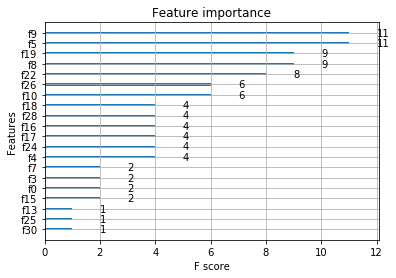

Accuracy: 97.50% (1.33%)



 20%|██        | 1/5 [00:01<00:07,  1.88s/it]

Score: 0.9819819819819819
Classes: [-1  0]
   train-error-mean  train-error-std  test-error-mean  test-error-std
0         -0.981859         0.004243        -0.981859        0.008484


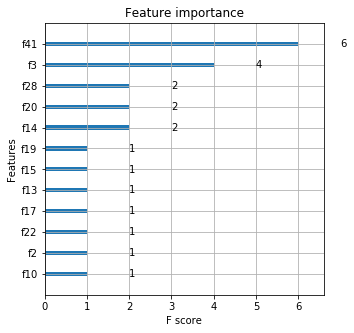


 40%|████      | 2/5 [00:02<00:04,  1.42s/it]

Accuracy: 98.19% (0.54%)
Score: 0.6756756756756757
Classes: [-1  0  1]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0       5.442167e-02         0.077910         0.092970        0.088581
1       3.174600e-02         0.078568         0.120181        0.063167
2       2.721100e-02         0.074675         0.113379        0.086108
3       3.061233e-02         0.043381         0.122449        0.088871
4       4.308400e-02         0.035166         0.102041        0.085509
5       4.308367e-02         0.039504         0.092971        0.083562
6       4.988667e-02         0.044116         0.090703        0.086108
7       5.102033e-02         0.038881         0.081633        0.075138
8       3.514767e-02         0.028906         0.097506        0.077828
9       2.607733e-02         0.022275         0.090703        0.073338
10      1.360533e-02         0.038881         0.083900        0.075412
11     -3.333333e-07         0.047457         0.079365        0.078026
12    

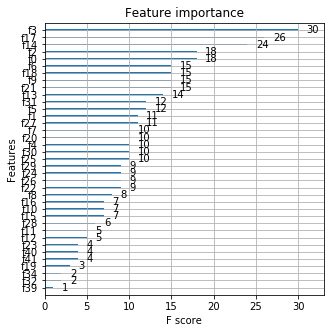


 60%|██████    | 3/5 [00:03<00:02,  1.25s/it]

Accuracy: 63.26% (1.26%)
Score: 0.8108108108108109
Classes: [0 1 2 3 4 5 6]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0          -1.180272         0.024684        -0.784580        0.239183
1          -1.252835         0.023620        -0.995465        0.108607
2          -1.244898         0.042027        -1.058957        0.051609
3          -1.162132         0.050932        -0.979592        0.047457
4          -1.181406         0.018491        -1.002268        0.023125
5          -1.210884         0.019440        -1.018141        0.023125
6          -1.218821         0.024264        -1.009070        0.012827
7          -1.231292         0.005554        -1.034014        0.060080
8          -1.226757         0.004242        -1.029478        0.047889
9          -1.229025         0.003206        -1.058957        0.069891
10         -1.235828         0.008484        -1.072562        0.057006
11         -1.239229         0.011224        -1.070294        0.050399
1

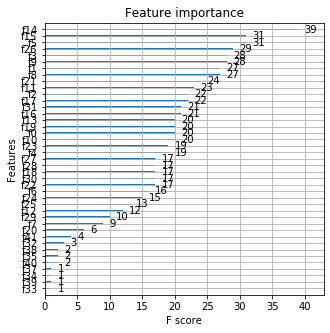


 80%|████████  | 4/5 [00:04<00:01,  1.15s/it]

Accuracy: 79.99% (5.45%)
Score: 0.40540540540540543
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
   train-error-mean  train-error-std  test-error-mean  test-error-std
0        -14.232426         0.434606       -12.961451        0.376567
1        -14.304989         0.475780       -14.306123        0.951523
2        -14.308390         0.473921       -14.312925        0.955599


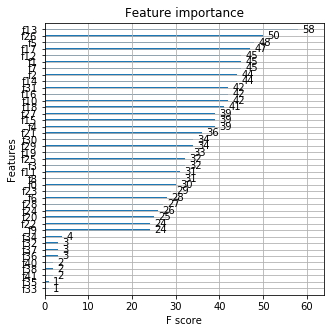


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: 51.48% (4.99%)
Score: 0.9819819819819819
Classes: [0 1]



 20%|██        | 1/5 [00:01<00:04,  1.22s/it]

Accuracy: 97.28% (0.55%)
Score: 0.9819819819819819
Classes: [-1  0]



 40%|████      | 2/5 [00:01<00:03,  1.01s/it]

Accuracy: 99.10% (1.10%)
Score: 0.7027027027027027
Classes: [-1  0  1]



 60%|██████    | 3/5 [00:03<00:02,  1.16s/it]

Accuracy: 65.07% (4.15%)
Score: 0.8648648648648649
Classes: [0 1 2 3 4 5 6]



 80%|████████  | 4/5 [00:06<00:01,  1.81s/it]

Accuracy: 81.60% (5.57%)
Score: 0.5225225225225225
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]



  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: 56.49% (3.70%)



  0%|          | 0/5 [00:00<?, ?it/s]

Baseline Score: 0.9009009009009009



 20%|██        | 1/5 [07:38<30:32, 458.12s/it]

Tuned Parameters: {'max_depth': 13.0, 'max_features': 20, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4}
Best score is 0.9242424242424242
Baseline Score: 0.9819819819819819



 40%|████      | 2/5 [14:57<22:37, 452.48s/it]

Tuned Parameters: {'max_depth': 1.0, 'max_features': 1, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
Best score is 0.9818181818181818
Baseline Score: 0.6666666666666666



 60%|██████    | 3/5 [22:50<15:17, 458.63s/it]

Tuned Parameters: {'max_depth': 16.0, 'max_features': 17, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4}
Best score is 0.6848484848484848
Baseline Score: 0.7657657657657657



 80%|████████  | 4/5 [30:33<07:40, 460.07s/it]

Tuned Parameters: {'max_depth': 9.0, 'max_features': 18, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}
Best score is 0.6545454545454545
Baseline Score: 0.3153153153153153



 60%|██████    | 3/5 [00:00<00:00, 19.84it/s]

Tuned Parameters: {'max_depth': 21.0, 'max_features': 14, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}
Best score is 0.2515151515151515
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.990909090909091
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.990909090909091
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.6303030303030303



 80%|████████  | 4/5 [00:00<00:00, 12.68it/s]

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.7909090909090909
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.6484848484848484



100%|██████████| 5/5 [39:34<00:00, 496.29s/it]


In [0]:
model_comparison_city_df = classification_models_fx(city_data_scaled, clusters_city_data, 
                                               list_class_models)
model_comparison_city_df.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/model_comparison_city.csv')


In [0]:
model_comparison_city_df

,xgboost_city_kmeans_score,xgboost_city_kmeans_std,xgboost_city_OPTICS_score,xgboost_city_OPTICS_std,xgboost_city_hdbscan_score,xgboost_city_hdbscan_std,xgboost_city_heirarchical_score,xgboost_city_heirarchical_std,xgboost_city_affinitypropagation_score,xgboost_city_affinitypropagation_std,lightgbm_city_kmeans_score,lightgbm_city_kmeans_std,lightgbm_city_OPTICS_score,lightgbm_city_OPTICS_std,lightgbm_city_hdbscan_score,lightgbm_city_hdbscan_std,lightgbm_city_heirarchical_score,lightgbm_city_heirarchical_std,lightgbm_city_affinitypropagation_score,lightgbm_city_affinitypropagation_std,randomforest_city_kmeans_score,randomforest_city_OPTICS_score,randomforest_city_hdbscan_score,randomforest_city_heirarchical_score,randomforest_city_affinitypropagation_score,decisiontree_city_kmeans_score,decisiontree_city_OPTICS_score,decisiontree_city_hdbscan_score,decisiontree_city_heirarchical_score,decisiontree_city_affinitypropagation_score,logreg_city_kmeans_score,logreg_city_OPTICS_score,logreg_city_hdbscan_score,logreg_city_heirarchical_score,logreg_city_affinitypropagation_score
score,97.499824,1.334243,98.191915,0.537793,63.258018,1.264024,79.994827,5.44951,51.484282,4.993929,97.280271,0.547602,99.101124,1.100894,65.074284,4.150591,81.595383,5.571719,56.489042,3.70258,0.972973,0.981982,0.648649,0.810811,0.441441,0.927928,0.981982,0.648649,0.612613,0.189189,0.990909,0.984848,0.609091,0.787879,0.575758


In [0]:
model_comparison_tract_df = classification_models_fx(tract_data_scaled, clusters_tract_data, 
                                               list_class_models_short)
model_comparison_tract_df.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/model_comparison_tract.csv')

  0%|          | 0/4 [00:00<?, ?it/s]

Baseline Score: 0.9542610250297974
Tuned Parameters: {'max_depth': 17.0, 'max_features': 23, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
Best score is 0.808253873659118



 25%|██▌       | 1/4 [1:07:47<3:23:22, 4067.51s/it]

Baseline Score: 0.9384684147794994



 50%|█████     | 2/4 [2:27:01<2:22:26, 4273.45s/it]

Tuned Parameters: {'max_depth': 1.0, 'max_features': 1, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
Best score is 0.9616607071911005
Baseline Score: 0.8636769964243146



 75%|███████▌  | 3/4 [4:02:44<1:18:34, 4714.25s/it]

Tuned Parameters: {'max_depth': 26.0, 'max_features': 23, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4}
Best score is 0.8423718712753278
Baseline Score: 0.9366805721096544



  0%|          | 0/4 [00:00<?, ?it/s]

Tuned Parameters: {'max_depth': 4.0, 'max_features': 27, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6}
Best score is 0.8471891140246325
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.9536650774731824



 25%|██▌       | 1/4 [00:06<00:19,  6.59s/it]

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.9616110448947159



 50%|█████     | 2/4 [02:38<01:40, 50.09s/it]

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.8911899086213747



 75%|███████▌  | 3/4 [06:20<01:41, 101.83s/it]

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.942938021454112



100%|██████████| 2/2 [5:16:53<00:00, 13154.21s/it]  


In [0]:
model_comparison_tract_df

,decisiontree_tract_kmeans_score,decisiontree_tract_OPTICS_score,decisiontree_tract_hdbscan_score,decisiontree_tract_heirarchical_score,logreg_tract_kmeans_score,logreg_tract_OPTICS_score,logreg_tract_hdbscan_score,logreg_tract_heirarchical_score
score,0.803784,0.957837,0.742104,0.844011,0.954013,0.961611,0.89119,0.94274


CITY DATA:
The best model is the LightGBM with the OPTICS classification method


TRACT DATA:
The best model is the LightGBM with the KMeans classification method

In [0]:
results = gbm_Class_fx(city_data_scaled, optic_city_df['optic_cluster'])
re2 = gbm_Class_fx(tract_data_scaled, kmeans_tract_df['cluster'])

Score: 0.9819819819819819
Classes: [-1  0]
Accuracy: 99.10% (1.10%)
Score: 0.9818235995232419
Classes: [0 1 2 3]
Accuracy: 97.81% (0.28%)


In [0]:
city_weights = results[0]
city_weights = city_weights.set_index('Feature')
tract_weights = re2[0]
tract_weights = tract_weights.set_index('Feature')

#### Ranking 

In [0]:
cc = list(city_data_scaled.columns)
tc = list(tract_data_scaled.columns)

In [0]:
# lists to sort columns for use in the upcoming function
ascending_false = ['Dental care','High school graduation','Income Inequality',
                   'Life expectancy','Park access','Preventive services',
                   'Racial/ethnic diversity','Third-grade reading proficiency',
                   'Walkability'] # good to be positive
ascending_true = ['Absenteeism','Air pollution - particulate matter',
                  'Binge drinking','Breast cancer deaths',
                  'Cardiovascular disease deaths', 'Children in Poverty',
                  'Colorectal cancer deaths','Diabetes',
                  'Frequent mental distress','Frequent physical distress', 
                  'High blood pressure', 'Housing cost, excessive',
                  'Housing with potential lead risk','Limited access to healthy foods',
                  'Neighborhood racial/ethnic segregation',
                  'Obesity','Opioid overdose deaths','Physical inactivity',
                  'Premature deaths (all causes)','Smoking','Unemployment',
                  'Uninsured','Violent crime','Lead exposure risk index']# good to be negative

In [0]:
# places features into a list that is only for tract data
a_false_tract = []
a_true_tract = []
for feat in tc:
  if feat in ascending_false:
    a_false_tract.append(feat)
  if feat in ascending_true:
    a_true_tract.append(feat)

In [0]:
def sorting_ranking_fx(df,a_false, a_true):
  '''this function sorts each column in ascending or decending order depending 
    on whether positive or negative values indicate better health.  

    args:
    df - city or tract dataframe
    a_false - a list of column names that are an indicator of good health 
    must only include the columns that are possible for the city/tract
    a_true - a list of column names that are an indicator of poor health must 
    only include the columns that are possible for the city/tract

    returns: dataframe of ranks for each location
  '''
  new_df = df.copy()
  for col in df.columns:
    if col in a_false:
      new_df = new_df.sort_values(col, ascending=False)
    if col in a_true:
      new_df = new_df.sort_values(col)
    new_df[col+'_rank'] = range(1, len(df[col])+1)
  names = list(new_df.columns)
  ranks = []
  for n in names:
    ranks.append(n.endswith('_rank'))
  just_ranks = new_df.loc[:, ranks]
  return just_ranks

In [0]:
# no LERI
city_no_leri = city_data_scaled.iloc[:, :-10]
city_reg_leri = city_no_leri.merge(leri_city, how='outer',left_index=True, right_index=True)
tract_no_leri = tract_data_scaled.iloc[:, :-10]
tract_reg_leri = tract_no_leri.merge(leri_tract, how='outer',left_index=True, right_index=True)

In [0]:
city_ranked = sorting_ranking_fx(city_no_leri, ascending_false, ascending_true)
tract_ranked = sorting_ranking_fx(tract_no_leri, a_false_tract, a_true_tract)

In [0]:
trc = list(tract_ranked.columns)
re.sub('\_rank$', '', trc[0])

'Air pollution - particulate matter'

##### Adding Weights

In [0]:
def feature_weights(df, weights):
  '''this function calculates the overall health score for each city/tract 
  by multiplying the ranked features by their corresponding weights. 

  args:
  df - ranked city or tract dataframe
  weights - calculated relative importance of each feature taken from classification 
  model

  returns: dataframe of scores for each location, sorted in descending order with 
  respect to overall health score.
  '''
  weighted_df = df.copy()
  for col in df.columns:
    weighted_df[col+'_w'] = df.loc[:, col]*weights.loc[re.sub('\_rank$', '', col)][0]
  names = list(weighted_df.columns)
  ws = []
  for n in names:
    ws.append(n.endswith('_w'))
  just_weights = weighted_df.loc[:, ws]
  w_cols = list(just_weights.columns)
  w_cols2 = []
  for w in w_cols:
    w_cols2.append(re.sub('\_rank_w$','',w))
  just_weights.columns = w_cols2
  just_weights.insert(0, 'Overall Health Score', just_weights.sum(axis=1))
  just_weights = just_weights.sort_values('Overall Health Score')
  just_weights.insert(0,'Overall Rank',range(1, len(just_weights['Overall Health Score'])+1))
  return(just_weights)

In [0]:
feature_weights(city_ranked, city_weights)

,Overall Rank,Overall Health Score,Absenteeism,Air pollution - particulate matter,Binge drinking,Breast cancer deaths,Cardiovascular disease deaths,Children in Poverty,Colorectal cancer deaths,Dental care,Diabetes,Frequent mental distress,Frequent physical distress,High blood pressure,High school graduation,"Housing cost, excessive",Housing with potential lead risk,Income Inequality,Life expectancy,Limited access to healthy foods,Neighborhood racial/ethnic segregation,Obesity,Opioid overdose deaths,Park access,Physical inactivity,Premature deaths (all causes),Preventive services,Racial/ethnic diversity,Smoking,Third-grade reading proficiency,Unemployment,Uninsured,Violent crime,Walkability
stpl_fips,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1342425,1,62011,1200,3684,3040,1644,21,1258,32,595,900,231,85,2464,104,2727,780,287,994,3367,459,90,7314,8189,1919,18,248,9234,465,342,2457,3139,16,4708
4827684,2,77965,375,3132,7277,11782,4599,592,472,1995,378,546,35,480,24,2929,156,164,1582,5330,1564,910,6900,4826,1178,918,400,12312,1050,18,455,2580,256,2750
613214,3,80881,950,5220,4161,3151,903,2072,2216,2275,2034,714,170,1136,368,25250,3198,1271,476,3536,629,135,2208,2755,874,378,1904,2430,300,468,2964,2064,128,4543
4801924,4,82418,700,3000,6232,6713,5985,2294,1696,3710,1062,1092,155,896,48,4141,624,697,770,4212,306,885,6486,2128,2489,594,448,13365,1380,12,754,5117,192,4235
636770,5,84063,525,4692,2299,4932,273,5328,720,1470,648,378,40,192,144,33229,2028,1681,154,572,765,20,7176,1577,228,90,320,8991,105,228,1976,1978,72,1232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740000,437,360725,9500,3168,703,42744,8169,31376,3096,13440,5292,8946,2010,6336,1800,21210,23868,17384,5614,5018,6256,1590,60030,5795,6137,7812,1616,31752,6330,1536,3133,11954,3216,3894
2241155,438,364211,7200,2544,2869,60143,9156,31006,3416,14595,7848,7749,1970,7024,2952,14443,22152,16195,6020,4394,7412,2175,51474,7999,7999,7902,3296,21303,6240,1674,4225,14749,3128,2959
3901000,439,366858,9750,4992,1140,44936,7581,30784,3328,14245,7326,8799,2025,6656,2984,20200,31590,17671,6048,3276,7089,2025,60306,2622,8094,7848,3352,23895,6540,2490,5057,9589,2816,1804


In [0]:
feature_weights(tract_ranked, tract_weights)

,Overall Rank,Overall Health Score,Air pollution - particulate matter,Binge drinking,Children in Poverty,Dental care,Diabetes,Frequent mental distress,High blood pressure,"Housing cost, excessive",Housing with potential lead risk,Income Inequality,Life expectancy,Limited access to healthy foods,Obesity,Physical inactivity,Preventive services,Racial/ethnic diversity,Smoking,Unemployment,Uninsured
stcotr_fips,,,,,,,,,,,,,,,,,,,,,
6085504901,1,33767485,1304901,3837202,4758019,1822392,276716,20826,63840,5019132,383223,84568,3751561,5630418,28866,897870,2306070,2196216,41760,1033045,310860
36061031703,2,35767652,2909052,11183110,5950854,181038,335634,365790,128160,1087780,216423,172019,436821,2758560,50374,713625,3934773,2908422,614394,1556823,264000
51510200702,3,35838069,2466504,10335473,1645749,1640496,595800,535602,903840,3655708,192654,1061905,383812,5017952,1695170,551005,121545,2946636,879570,254288,954360
34017007300,4,36060608,2958129,10610756,16954,356928,19860,167142,37920,2162408,192237,175863,369050,2952316,371862,2479955,6378156,763686,524088,2569138,2954160
49035104400,5,36817945,829692,3138729,387520,147576,1450442,699006,1733760,689932,7110684,1219509,1629859,5084453,1601780,198950,1555119,5055534,8874,1303226,2973300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13095010302,26844,290725988,2693421,243020,31851722,22644336,17433108,14085318,12668160,12523444,5350944,25281027,16639458,21483107,14975228,23048790,16953885,4918914,13894596,18359870,15677640
29510126700,26845,290746051,3783717,1163982,29983149,22628892,17485406,14272218,12215040,11567184,10772778,25122462,17678837,19213042,15117860,22403500,14700375,4210272,13997952,17561765,16867620
17031251700,26846,291030214,4212072,3409822,31230479,22331166,16909466,12846972,12546720,13199128,11073018,21694575,15655101,21660443,14930514,21466705,16820514,3999402,13190940,18164317,15688860
